<a href="https://colab.research.google.com/github/iguerrasevillano/TFM/blob/clean_version/Copia_de_TLDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements

In [1]:
!pip install datasets
!pip install rouge_score
!pip install huggingface_hub
!pip install tensorflow==2.15.0
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=6eed7773d7501e3b9c01a31c15754bdd44c6c887e499868a31e3a90ffbfb1a8c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.3 MB/s eta 0:00:00
  Attem

## Libraries

In [1]:
# LIBRARIES

import os
import pandas as pd
import numpy as np
import json
import shutil
import random

# Visualization
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split

# Keras
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import History

# Transformers
from datasets import Dataset, DatasetDict, load_metric
from transformers import BartTokenizer, T5Tokenizer, pipeline, TFT5ForConditionalGeneration
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay
from transformers.keras_callbacks import KerasMetricCallback
from transformers import PushToHubCallback

# NLTK
import nltk
nltk.download('punkt')

# AST
import ast

# Metrics
metric = load_metric('rouge', seed=42) #It is not deterministic

# Current directory
os.getcwd()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-1-d54cd7d9c1fe>:37: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge', seed=42) #It is not deterministic
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


'/content'

## Logins, Paths and Auxiliar Functions

In [2]:
# Connect w/ Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# PATHS
BASE_PATH = "/content/drive/MyDrive/VIU/TFM/Desarrollo/"

documents = os.listdir(BASE_PATH)

Mounted at /content/drive/


In [3]:
# AUXILIAR FUNCTIONS

# Function to convert strings to lists
def convert_to_list(cell):
    try:
        return ast.literal_eval(cell)
    except (SyntaxError, ValueError):
        return cell



# Function to join all the sentences of input document
def clean_data(data, column):
  data[column] = data[column].apply(lambda x : ' '.join(x))
  return data




# Define the metric to use (ROUGE Scores)
def metric_fn(eval_predictions):
  predictions, labels = eval_predictions

  for prediction in predictions:
      prediction[prediction < 0] = tokenizer.pad_token_id  # Replace masked prediction tokens

  decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

  for label in labels:
      label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens

  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # Rouge expects a newline after each sentence
  decoded_predictions = [
      "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
  ]
  decoded_labels = [
      "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
  ]
  result = metric.compute(
      predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
  )

  # Extract a few results
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

  # Add mean generated length
  prediction_lens = [
      np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
  ]
  result["gen_len"] = np.mean(prediction_lens)

  return result



  def plot_graphics(H):

    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    # Plot the training and validation loss for each epoch in the first subplot
    ax[0].plot(np.arange(0,len(H.history["loss"]) ), H.history["loss"], 'r', label="loss")
    ax[0].plot(np.arange(0,len(H.history["loss"])), H.history["val_loss"], 'c', label="val_loss")
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend(loc="upper right")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge1"], label="rouge1")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge2"], label="rouge2")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rougeL"], label="rougeL")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rougeLsum"], label="rougeLsum")
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('score')
    ax[1].legend()

## Preprocess Data

In [4]:
data = pd.read_csv(BASE_PATH+'Data/Dev/Results/Extractive/extractive_summaries.csv')

data['source'] = data['source'].apply(convert_to_list)
data = clean_data(data, 'source')

data.sample(5)

,source,paper_id,target,title,number_words_target,extractive_summary
256,Knowledge Bases (KBs) are becoming increasingl...,HkyI-5667,Probabilistic Rule Learning system using Lifte...,Scalable Rule Learning in Probabilistic Knowle...,30,"However, the ProbFOIL approach of De Raedt et ..."
904,RMSProp and ADAM continue to be extremely popu...,rkgd0iA9FQ,In this paper we prove convergence to critical...,Convergence Guarantees for RMSProp and ADAM in...,48,We show that at very high values of the moment...
1208,Principal Filter Analysis (PFA) is an easy to ...,rkl42iA5t7,"We propose an easy to implement, yet effective...",NETWORK COMPRESSION USING CORRELATION ANALYSIS...,90,We propose two closed-form algorithms based on...
522,While Bayesian optimization (BO) has achieved ...,SknC0bW0-,We propose a Bayes-optimal Bayesian optimizati...,Continuous-fidelity Bayesian Optimization with...,34,While Bayesian optimization (BO) has achieved ...
429,We study the problem of representation learnin...,H1emus0qF7,We translate a bound on sub-optimality of repr...,Near-Optimal Representation Learning for Hiera...,79,"To study this problem, we develop a notion of ..."


In [7]:
# random.seed(42)

# def shuffle_list(text):
#     lst = text.split('. ')
#     lst[:-1] = [sentence + '.' for sentence in lst[:-1]]
#     random.shuffle(lst)
#     return ' '.join(lst)

# data['target'] = data['target'].apply(shuffle_list)

In [5]:
# Count number of words of source and target
def count_words(data, column):
  return data[column].apply(lambda x : len(x.split()))

data['number_words_target'] = count_words(data, 'target')
data['number_words_source'] = count_words(data, 'source')
data['number_words_extractive'] = count_words(data, 'extractive_summary')

In [6]:
print(data['number_words_target'].describe())
print(data['number_words_source'].describe())
print(data['number_words_extractive'].describe())

count    1312.000000
mean       58.935213
std        20.402388
min        30.000000
25%        41.000000
50%        58.000000
75%        73.000000
max       149.000000
Name: number_words_target, dtype: float64
count     1312.000000
mean      5177.437500
std       2107.094236
min        126.000000
25%       4069.750000
50%       5001.500000
75%       6187.750000
max      24589.000000
Name: number_words_source, dtype: float64
count    1312.000000
mean      621.176067
std       143.951058
min       126.000000
25%       534.000000
50%       611.000000
75%       693.000000
max      1199.000000
Name: number_words_extractive, dtype: float64


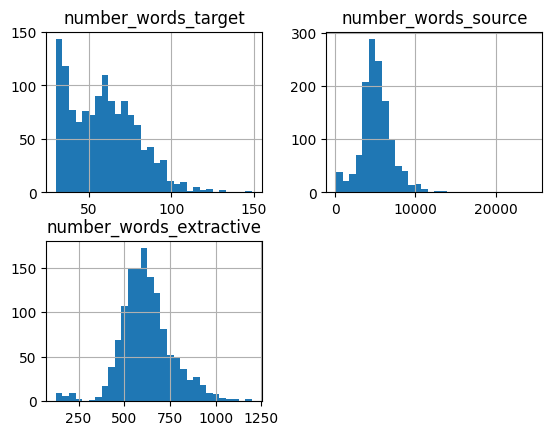

In [8]:
# Histogramas
data.hist(bins=30)
plt.show()

In [9]:
data = data[data['number_words_target']>=40].reset_index(drop=True)
data['number_words_target'].describe()

count    1012.000000
mean       66.381423
std        17.169049
min        40.000000
25%        54.000000
50%        64.000000
75%        77.000000
max       149.000000
Name: number_words_target, dtype: float64

In [10]:
synonyms_paper = ['paper', 'study', 'work', 'article']
articles = ['The', 'the', 'This', 'this', 'A', 'a', 'An', 'an']

def substitution(text, syn, articles):
  list_words = text.split()
  new_list_words = []
  for index, word in enumerate(list_words):
    if word in articles and list_words[index+1] in syn:
      new_list_words.append(word)
      new_list_words.append(random.choice(syn))
    elif word in syn and list_words[index-1] in articles:
      continue
    else:
      new_list_words.append(word)
  return ' '.join(new_list_words)

data['extractive_summary'] = data['extractive_summary'].apply(lambda x : substitution(x, synonyms_paper, articles))
data['target'] = data['target'].apply(lambda x : substitution(x, synonyms_paper, articles))

In [11]:
# Split data in different sets
data_training, data_test = train_test_split(data,
                                      test_size=0.20,
                                      shuffle=True,
                                      random_state=42)

data_train, data_val = train_test_split(data_training,
                                        test_size=0.20,
                                        shuffle=True,
                                        random_state=42)

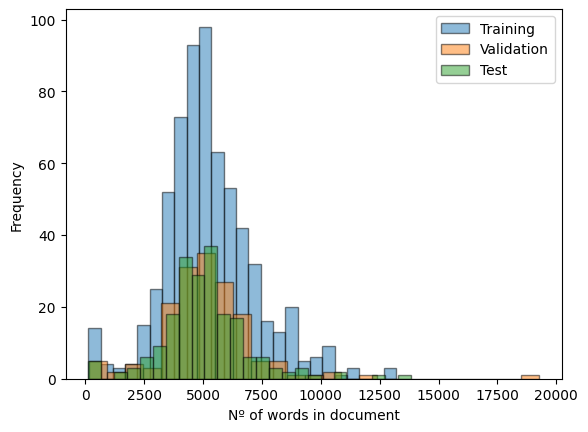

In [22]:
plt.hist(data_train['number_words_source'], bins=25, edgecolor='black', alpha=0.5, label='Training')
plt.hist(data_val['number_words_source'], bins=25, edgecolor='black', alpha=0.5, label='Validation')
plt.hist(data_test['number_words_source'], bins=25, edgecolor='black', alpha=0.5, label='Test')


plt.xlabel('Nº of words in document')
plt.ylabel('Frequency')
plt.legend()

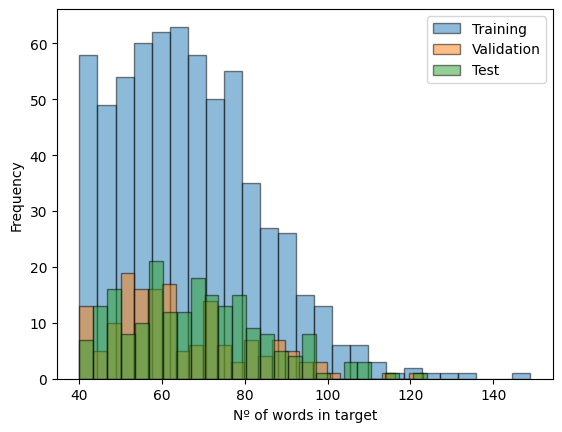

In [23]:
plt.hist(data_train['number_words_target'], bins=25, edgecolor='black', alpha=0.5, label='Training')
plt.hist(data_val['number_words_target'], bins=25, edgecolor='black', alpha=0.5, label='Validation')
plt.hist(data_test['number_words_target'], bins=25, edgecolor='black', alpha=0.5, label='Test')


plt.xlabel('Nº of words in target')
plt.ylabel('Frequency')
plt.legend()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(16, 8),  sharey=True)

clean_data[['number_words_source', 'number_words_target']].hist(ax=ax,
              bins=25,
              edgecolor='black',
              grid=False)

ax[0].set_xlabel('Nº of words in document')
ax[1].set_xlabel('Nº of words in target')

In [11]:
data_test.head(5)

,source,paper_id,target,title,number_words_target,extractive_summary,number_words_source,number_words_extractive
631,With the recently rapid development in deep le...,ByxmXnA9FQ,A new framework based variational inference fo...,A Variational Dirichlet Framework for Out-of-D...,78,"Therefore, it is very essential to design a ro...",3289,695
634,Neural machine translation (NMT) models learn ...,H1z-PsR5KX,"Unsupervised methods for finding, analyzing, a...",Identifying and Controlling Important Neurons ...,54,"First, it targets the whole vector representat...",4933,456
963,Recent results from linear algebra stating tha...,SkeUG30cFQ,We provide a theoretical study of the properti...,The Expressive Power of Deep Neural Networks w...,54,Recent results from linear algebra stating tha...,4143,594
625,Analogical reasoning has been a principal focu...,SylLYsCcFm,The most robust capacity for analogical reason...,Learning to Make Analogies by Contrasting Abst...,67,"It is natural to consider, however, whether th...",6473,673
365,Recent advances in computing technology and se...,ByJbJwxCW,We propose a deep Multi Instance Learning fram...,Relational Multi-Instance Learning for Concept...,97,Most of the medical time series lack annotatio...,4819,513


In [12]:
print(data_train.shape, data_val.shape, data_training.shape, data_test.shape)

(647, 8) (162, 8) (809, 8) (203, 8)


In [13]:
# Convert all data to HF DatasetDict
tf_data_train = Dataset.from_pandas(data_train)
tf_data_test = Dataset.from_pandas(data_test)
tf_data_val = Dataset.from_pandas(data_val)

raw_data = DatasetDict({'train': tf_data_train,
                           'validation': tf_data_val,
                           'test': tf_data_test})

## BART



In [39]:
model_name = 'facebook/bart-base'
max_input_length = 1024

save_name = 'sampling-norep-v4/'
save_path = BASE_PATH + '/Results/TLDR/BART/model_save/' + save_name

#### Prepare Data for Tokenization

In [20]:
# Tokenize data
tokenizer = BartTokenizer.from_pretrained(model_name, errors='ignore')

# Function in order to tokenize source and target

def tokenize_function(data):
  model_inputs = tokenizer(data['extractive_summary'], max_length=max_input_length, truncation=True, padding=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(data['target'], padding=True)

  # The target input_ids tokens are added to the model inputs
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

tokenized_data = raw_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/647 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/162 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

### Prepare Data for Training

In [45]:
# BART generation config parameters
forbidden_begin_tokens = [tokenizer.convert_tokens_to_ids('We')]

forbidden_tokens = [
     # tokenizer.convert_tokens_to_ids('Ġpaper'),
     tokenizer.convert_tokens_to_ids('ĠPro'),
     # tokenizer.convert_tokens_to_ids('Ġauthors'),
     tokenizer.convert_tokens_to_ids('ĠIntrodu')]
     #  tokenizer.convert_tokens_to_ids('Ġwork'),
     #  tokenizer.convert_tokens_to_ids('Ġmethod')]

BART_generation_parameters = {
    'max_length' : 150,
    'min_length' : 60,
    'length_penalty' : 2.0,
    'do_sample' : True,
    'num_beams' : 4,
    'temperature' : 0.5,
    'begin_suppress_tokens' : forbidden_begin_tokens,
    'suppress_tokens' : forbidden_tokens,
    'repetition_penalty' : 1.8,
    'no_repeat_ngram_size' : 3
}


# Training hyper-parameters
epochs = 10
batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01

In [48]:
# Load BART Base-Model
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name,
                                                **BART_generation_parameters)

#model.generation_config = BART_generation_parameters

if not model.generation_config.do_sample:
  model.generation_config.num_beam_groups = 4
  model.generation_config.diversity_penalty = 0.5

use_XLA = False
if use_XLA:
  model.generation_config.no_repeat_ngram_size = 0 # In order to use XLA Generation

print(model.generation_config)

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


GenerationConfig {
  "begin_suppress_tokens": [
    170
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "do_sample": true,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 150,
  "min_length": 60,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.8,
  "suppress_tokens": [
    1698,
    32687
  ],
  "temperature": 0.5
}



In [44]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", padding=True)

if use_XLA:
  generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", pad_to_multiple_of=128)
else:
  generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", padding=True)

In [ ]:
train_dataset = model.prepare_tf_dataset(
    tokenized_data['train'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
    drop_remainder=False,
)

validation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

generation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=2*batch_size,
    shuffle=False,
    collate_fn=generation_data_collator
)

In [ ]:
# Compile model
optimizer = AdamWeightDecay(
    learning_rate=learning_rate,
    weight_decay_rate=weight_decay
)

model.compile(optimizer=optimizer)

model.summary()

Model: "tf_bart_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  139420416 
                                                                 
 final_logits_bias (BiasLay  multiple                  50265     
 er)                                                             
                                                                 
Total params: 139470681 (532.04 MB)
Trainable params: 139420416 (531.85 MB)
Non-trainable params: 50265 (196.35 KB)
_________________________________________________________________


In [ ]:
#tensorboard_callback = TensorBoard(log_dir=BART_PATH+'/BART_model_save/logs')

metric_callback = KerasMetricCallback(
    metric_fn,
    eval_dataset=generation_dataset,
    predict_with_generate=True,
    use_xla_generation=use_XLA
)

# push_to_hub_callback = PushToHubCallback(
#     output_dir="./model_save",
#     tokenizer=tokenizer,
#     hub_model_id="iguerrasevillano/BART-summ-v1",
#     save_strategy='epoch',
#     checkpoint=True
# )


checkpoint_callback = ModelCheckpoint(
    filepath=save_path+"/weights.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
)

stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
callbacks = [metric_callback,
            #  push_to_hub_callback,
             stop_early,
             checkpoint_callback]

# Train
print('[INFO: fine-tuning model...]')
H = model.fit(train_dataset,
              validation_data=validation_dataset,
              epochs=epochs, callbacks=callbacks)

# Save the model and tokenizer to a directory
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

[INFO: fine-tuning model...]
Epoch 1/10


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
81/81 [==============================] - 4104s 50s/step - loss: 3.8688 - val_loss: 3.3719 - rouge1: 39.2353 - rouge2: 10.1921 - rougeL: 22.2063 - rougeLsum: 32.0559 - gen_len: 86.5864
Epoch 2/10
81/81 [==============================] - 3653s 45s/step - loss: 3.5389 - val_loss: 3.3010 - rouge1: 39.3726 - rouge2: 10.5648 - rougeL: 22.4130 - rougeLsum: 32.1531 - gen_len: 84.8519
Epoch 3/10
81/81 [==============================] - 3281s 41s/step - loss: 3.3532 - val_loss: 3.2627 - rouge1: 39.5196 - rouge2: 10.8404 - rougeL: 22.6945 - rougeLsum: 32.3229 - gen_len: 83.2654
Epoch 4/10
81/81 [==============================] - 3475s 43s/step - loss: 3.2109 - val_loss: 3.2532 - rouge1: 39.6113 - rouge2: 10.6516 - rougeL: 22.5902 - rougeLsum: 32.1820 - gen_len: 82.9136
Epoch 5/10
81/81 [==============================] - 3333s 41s/step - loss: 3.0813 - val_loss:

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v4/tokenizer_config.json',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v4/special_tokens_map.json',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v4/vocab.json',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v4/merges.txt',
 '/content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v4/added_tokens.json')

In [ ]:
with open(save_path + 'training_history.json', 'w') as file:
    json.dump(H.history, file)

In [ ]:
# List all files in the source folder
weights_last_epoch = 'tf_model.h5'

source_file_path = os.path.join(save_path, weights_last_epoch)
os.makedirs(save_path + 'last_epoch/')
destination_file_path = os.path.join(save_path, 'last_epoch/', weights_last_epoch)
shutil.move(source_file_path, destination_file_path)

print(f"File {weights_last_epoch} moved from {source_file_path} to {destination_file_path}")

File tf_model.h5 moved from /content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v4/tf_model.h5 to /content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v4/last_epoch/tf_model.h5


In [ ]:
# Change name
original_path = save_path + '/weights.h5'
new_name = 'tf_model.h5'

# Create the new file path
new_path = os.path.join(os.path.dirname(original_path), new_name)

# Rename the file
os.rename(original_path, new_path)

print(f"File weights.h5 renamed as {new_name}")

File weights.h5 renamed as tf_model.h5


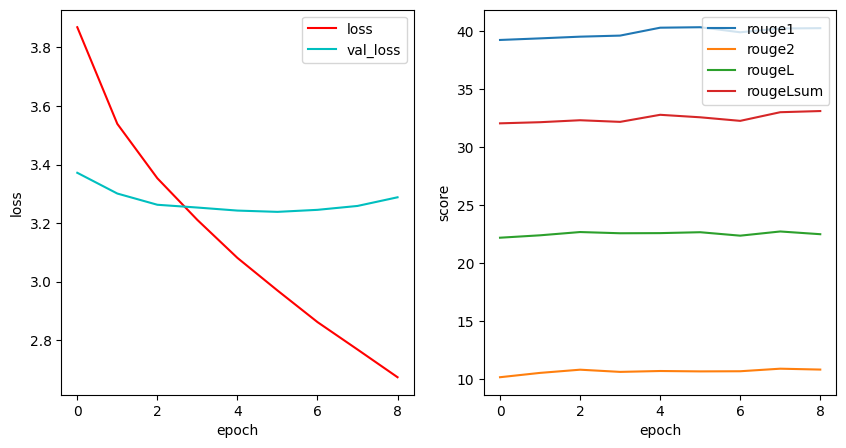

In [ ]:
plot_graphics(H)
plt.savefig(save_path + '/history.png')

## T5

In [14]:
model_name = 'google-t5/t5-small'
max_input_length = 1024

save_name = 'greedy-norep-v4/'
save_path = BASE_PATH + '/Results/TLDR/T5/model_save/' + save_name

In [15]:
# Tokenize data
tokenizer = T5Tokenizer.from_pretrained(model_name, errors='ignore')
prefix = 'summarize: '

# Function in order to tokenize source and target
max_input_length = 512

def tokenize_function(data):
  inputs = [prefix + input for input in data['extractive_summary']]
  model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(data['target'], padding=True)

  # The target input_ids tokens are added to the model inputs
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

tokenized_data = raw_data.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have

Map:   0%|          | 0/647 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/162 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

In [17]:
# T5 generation config parameters
forbidden_begin_tokens = [tokenizer.convert_tokens_to_ids('We')]

forbidden_tokens = [
     # tokenizer.convert_tokens_to_ids('Ġpaper'),
     tokenizer.convert_tokens_to_ids('ĠPro'),
     # tokenizer.convert_tokens_to_ids('Ġauthors'),
     tokenizer.convert_tokens_to_ids('ĠIntrodu')]
     #  tokenizer.convert_tokens_to_ids('Ġwork'),
     #  tokenizer.convert_tokens_to_ids('Ġmethod')]

forbidden_words = ['We', 'we', 'propose', 'Proposes']

T5_generation_parameters = {
    'max_length' : 100,
    'min_length' : 60,
    'length_penalty' : 2.0,
    'num_beams' : 4,
    'do_sample' : False,
    'temperature' : 0.5,
    'bad_words_ids' : tokenizer(forbidden_words,
                                add_special_tokens=False).input_ids,
    'repetition_penalty' : 1.8,
    'no_repeat_ngram_size' : 3
}


# Training hyper-parameters
epochs = 12
batch_size = 8
learning_rate = 2e-4
weight_decay = 0.01

In [18]:
# Load T5 Base-Model
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)


if not model.generation_config.do_sample:
  model.generation_config.num_beam_groups = 4
  model.generation_config.diversity_penalty = 0.5


print(model.generation_config)

use_XLA = False

batch_size = 8
learning_rate = 2e-4
weight_decay = 0.01

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


GenerationConfig {
  "decoder_start_token_id": 0,
  "diversity_penalty": 0.5,
  "eos_token_id": 1,
  "num_beam_groups": 4,
  "pad_token_id": 0
}



In [19]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", padding=True, pad_to_multiple_of=128)

if use_XLA:
  generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", pad_to_multiple_of=128)
else:
  generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", padding=True, pad_to_multiple_of=128)

In [20]:
train_dataset = model.prepare_tf_dataset(
    tokenized_data['train'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
    drop_remainder=False,
)

validation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

generation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=2*batch_size,
    shuffle=False,
    collate_fn=generation_data_collator
)

In [21]:
# Compile model
optimizer = AdamWeightDecay(
    learning_rate=learning_rate, weight_decay_rate=weight_decay
)

model.compile(optimizer=optimizer)

model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
metric_callback = KerasMetricCallback(
    metric_fn,
    eval_dataset=generation_dataset,
    predict_with_generate=True,
    use_xla_generation=use_XLA
)


checkpoint_callback = ModelCheckpoint(
    filepath=save_path+"/weights.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
)

stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [23]:
callbacks = [metric_callback,
            #  push_to_hub_callback,
             stop_early,
             checkpoint_callback]

# Train
print('[INFO: fine-tuning model...]')
H = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=callbacks)

# Save the model and tokenizer to a directory
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

[INFO: fine-tuning model...]
Epoch 1/12


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
81/81 [==============================] - ETA: 0s - loss: 2.2949

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:458: UserWarning: `num_beams` is set to 1. However, `num_beam_groups` is set to `4` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `num_beam_groups`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:465: UserWarning: `num_beams` is set to 1. However, `diversity_penalty` is set to `0.5` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `diversity_penalty`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:837: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


81/81 [==============================] - 482s 5s/step - loss: 2.2949 - val_loss: 1.9815 - rouge1: 0.0000e+00 - rouge2: 0.0000e+00 - rougeL: 0.0000e+00 - rougeLsum: 0.0000e+00 - gen_len: 0.0000e+00
Epoch 2/12
42/81 [==============>...............] - ETA: 3:40 - loss: 1.7548

KeyboardInterrupt: 

In [ ]:
plot_graphics(H)
plt.savefig(save_path + '/history.png')

## Evaluation

In [ ]:
name_models = {
              #  'sampling-norep-v1' : 'sampling-norep-v1/',
              #  'greedy-norep-v0' : 'greedy-norep-v0/',
              #  'greedy-norep-v1' : 'greedy-norep-v1/',
              #  'greedy-norep-v2' : 'greedy-norep-v2/',
              'greedy-norep-v4' : 'greedy-norep-v4/'}
              #  'sampling-norep-v3' : 'sampling-norep-v3',
              #  'sampling-norep-v4' : 'sampling-norep-v4'}

model = 'T5/'


save_paths = {}
models = {}
# tokenizers = {}

for name in name_models:
  save_paths[name] = BASE_PATH + '/Results/TLDR/' + model + 'model_save/' + name_models[name]

  models[name] = TFAutoModelForSeq2SeqLM.from_pretrained(save_paths[name])
  # tokenizers[name] = BartTokenizer.from_pretrained(save_path[name])
  print(models[name].generation_config)

In [ ]:
name = 'greedy-norep-v4'

In [68]:
ids = models[name].generate(tokenized_data['test']['input_ids'][:1],
                                        generation_config=models[name].generation_config,
                                        seed=42)

In [69]:
tokenizer.batch_decode(ids, skip_special_tokens=True)

['A variational Dirichlet algorithm for deep neural network classification problem and a smoothing method to alleviate the over-concentration issue. This paper introduces a variational dirichlet framework for deep image classification problems, which can greatly widen the distance between in-and out-of-distribution datasets.']

In [ ]:
name = 'greedy-norep-v4'

generated_summaries = []
rouge_scores = []
accumulated_metrics = {}

n = len(tokenized_data['test']['input_ids'])
batch_size = 2 # Must be greater than 1

# Last batch is dropped (just one sample if batch_size=2) to average ROUGE scores properly
for i in range(0, n-1, batch_size):
  if i % 10 == 0:
    print(f'[INFO]: {i}/{n-1}')


  generated_ids = models[name].generate(tokenized_data['test']['input_ids'][i:i+batch_size],
                                        generation_config=models[name].generation_config,
                                        seed=42)
  reference_labels = np.array(tokenized_data['test']['labels'][i:i+batch_size])

  predicted_labels = np.array(generated_ids)

  current_metrics = metric_fn((predicted_labels, reference_labels))
  accumulated_metrics = {k : current_metrics.get(k, 0) + accumulated_metrics.get(k, 0) for k in current_metrics.keys()}

  # Predicted summaries, keep the rouge scores
  generated_summaries.append(tokenizer.batch_decode(generated_ids, skip_special_tokens=True))
  rouge_scores.append(current_metrics)

# Undo nested list
generated_summaries = [summary for summaries in generated_summaries for summary in summaries]
average_rouge_scores = {k : accumulated_metrics.get(k, 0)/len(range(0, n-1, batch_size)) for k in accumulated_metrics.keys()}

In [ ]:
updated_data_test = data_test[:-1].reset_index(drop=True)
updated_data_test['abstractive_summary'] = pd.Series(generated_summaries)

updated_data_test['number_words_abstractive'] = count_words(updated_data_test, 'abstractive_summary')

updated_data_test['length_difference'] = updated_data_test['number_words_target'] - updated_data_test['number_words_abstractive']

updated_data_test.to_csv(save_path + '/updated_data_test.csv', index=False)

summaries = updated_data_test[['target', 'abstractive_summary']]
summaries.to_csv(save_path + '/summaries.csv', index=False)

with open(save_path + '/average_rouge_scores.json', 'w') as json_scores:
    json.dump(average_rouge_scores, json_scores, indent=4)

In [72]:
updated_data_test['length_difference'].describe()

count    202.000000
mean       3.683168
std       19.394276
min      -42.000000
25%      -10.000000
50%        4.000000
75%       16.000000
max       59.000000
Name: length_difference, dtype: float64

In [78]:
updated_data_test['abstractive_summary'][130]

'A method to generate out-distribution samples from over-generalized regions, reducing the risk of misclassifying both adversaries and samples using augmented CNNs. This paper introduces a method for learning out-department samples in a "dustbin" sub-manifold, which can be used to train out-destribution examples.'